## Modélisation par des lois : choix d’un modèle pour `DEC_MED21`

Dans l’exemple (vélos), la variable d’intérêt était un **compte** (discret), donc la démarche a commencé par une **loi de Poisson**, puis a été ajustée vers une **binomiale négative** en présence de sur-dispersion :contentReference[oaicite:1]{index=1}.

Ici, `DEC_MED21` est une variable **continue**, **positive**, généralement **asymétrique à droite** (queue vers les grandes valeurs).  
On teste donc des lois adaptées aux montants économiques.

On note :

\[
X = \text{DEC\_MED21} \quad (X>0)
\]

---

### Hypothèse 1 : Loi log-normale

#### Théorie
On suppose :

\[
X \sim \text{LogNormal}(\mu,\sigma^2)
\quad \Longleftrightarrow \quad
\log(X) \sim \mathcal{N}(\mu,\sigma^2)
\]

Propriétés :

\[
\mathbb{E}[X] = \exp\left(\mu + \frac{\sigma^2}{2}\right),
\qquad
\mathrm{Var}(X) = \left(\exp(\sigma^2)-1\right)\exp\left(2\mu+\sigma^2\right)
\]

#### Vérification empirique
- Histogramme de `DEC_MED21`
- Histogramme de `log(DEC_MED21)`
- QQ-plot de `log(DEC_MED21)` contre une normale

---

### Hypothèse 2 : Loi Gamma

#### Théorie
On suppose :

\[
X \sim \Gamma(\alpha, \theta)
\]

(où \(\alpha>0\) est le paramètre de forme et \(\theta>0\) l’échelle)

Propriétés :

\[
\mathbb{E}[X] = \alpha\theta,
\qquad
\mathrm{Var}(X) = \alpha\theta^2
\]

#### Estimation (méthode des moments)
Si \(\bar{X}\) est la moyenne empirique et \(S^2\) la variance empirique :

\[
\hat{\alpha} = \frac{\bar{X}^2}{S^2},
\qquad
\hat{\theta} = \frac{S^2}{\bar{X}}
\]

---

### Hypothèse 3 : Loi de Pareto (pour la queue)

La loi de Pareto est rarement un bon modèle *global*, mais elle est très utile pour modéliser la **queue** (ex : les 5% ou 10% plus élevés).

#### Théorie
Pour \(x\ge x_{\min}>0\) :

\[
\mathbb{P}(X \ge x) = \left(\frac{x_{\min}}{x}\right)^{\alpha}
\]

#### Idée pratique
On choisit un seuil \(x_{\min}\) (ex : quantile 0.90 ou 0.95), puis on ajuste Pareto sur les valeurs \(X \ge x_{\min}\).

---


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats



## Chargement des données et Dataprep

In [16]:
path = "dataset/BASE_TD_FILO_IRIS_2021_DEC.csv"


df = pd.read_csv(path, sep=";", decimal=",")
# Identify columns that contain numerical values with comma
num_cols = [col for col in df.columns if df[col].str.contains(",", na=False).any()]

# Convert them: replace "," -> "." then cast to float
for col in num_cols:
    df[col] = df[col].str.replace(",", ".", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

#columns with 60% of NAN
col_NaN = [c for c in df.columns if df[c].isnull().mean()*100 > 60.0]
print("number of columns with  60% of NaN",len(col_NaN))

quasi_constant = df.columns[
    df.apply(
        lambda x : x.value_counts(normalize=True).iloc[0]
        if x.dropna().size > 0 else 0
    ) > 0.90
]
print("\n nb de colonnes avec 90 % des données avec la même valeur :", len(quasi_constant))

number of columns with  60% of NaN 0

 nb de colonnes avec 90 % des données avec la même valeur : 0


In [17]:
def audit(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique": df.nunique(),
        "sample": df.iloc[0]
    })


audit(df)

,dtype,missing,missing_%,unique,sample
IRIS,object,0,0.00,16026,010040101
DEC_PIMP21,float64,1536,9.58,83,43.0
DEC_TP6021,float64,1537,9.59,85,29.0
DEC_INCERT21,object,0,0.00,3,2
DEC_Q121,object,0,0.00,2737,12610
DEC_MED21,object,0,0.00,3498,19330
DEC_Q321,object,0,0.00,4343,26390
DEC_EQ21,float64,1536,9.58,190,0.71
DEC_D121,object,0,0.00,1953,7760
DEC_D221,object,0,0.00,2573,11300


In [18]:
df = df.dropna()
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts

IRIS            0
DEC_PIMP21      0
DEC_TP6021      0
DEC_INCERT21    0
DEC_Q121        0
DEC_MED21       0
DEC_Q321        0
DEC_EQ21        0
DEC_D121        0
DEC_D221        0
DEC_D321        0
DEC_D421        0
DEC_D621        0
DEC_D721        0
DEC_D821        0
DEC_D921        0
DEC_RD21        0
DEC_S80S2021    0
DEC_GI21        0
DEC_PACT21      0
DEC_PTSA21      0
DEC_PCHO21      0
DEC_PBEN21      0
DEC_PPEN21      0
DEC_PAUT21      0
DEC_NOTE21      0
dtype: int64

In [19]:
df.shape

(13674, 26)

In [20]:
df.describe()

,DEC_PIMP21,DEC_TP6021,DEC_EQ21,DEC_RD21,DEC_S80S2021,DEC_GI21,DEC_PACT21,DEC_PTSA21,DEC_PCHO21,DEC_PBEN21,DEC_PPEN21,DEC_PAUT21
count,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000
mean,53.881600,24.743235,0.819758,18.694669,9.932280,0.362767,68.288409,60.762608,3.254073,4.271727,26.124448,5.587143
std,14.230925,13.594410,0.191954,148.426722,6.484679,0.063986,9.691292,9.789245,1.256660,2.418706,8.940358,5.200029
min,7.000000,3.000000,0.410000,2.400000,2.800000,0.198000,19.400000,16.500000,0.400000,0.200000,-0.300000,0.000000
25%,43.000000,14.000000,0.670000,4.500000,5.900000,0.319000,62.300000,54.600000,2.400000,2.500000,19.600000,2.700000
50%,54.000000,22.000000,0.790000,6.200000,8.100000,0.358000,68.800000,61.400000,3.000000,3.800000,25.500000,4.300000
75%,65.000000,33.000000,0.940000,9.200000,11.500000,0.399000,75.100000,67.800000,3.900000,5.500000,31.900000,6.600000
max,91.000000,83.000000,1.870000,6617.000000,150.300000,0.803000,98.200000,96.500000,13.300000,31.700000,66.400000,69.500000


In [21]:
vars_of_interest = [
    "DEC_MED21",    # Revenu médian
    "DEC_TP6021",   # Taux de pauvreté
    "DEC_PIMP21"    # Part des impôts
]

subset = df[vars_of_interest].copy()
subset.head()


,DEC_MED21,DEC_TP6021,DEC_PIMP21
0,19330,29.0,43.0
1,16830,39.0,42.0
2,19940,29.0,47.0
3,25560,14.0,62.0
4,19870,31.0,42.0


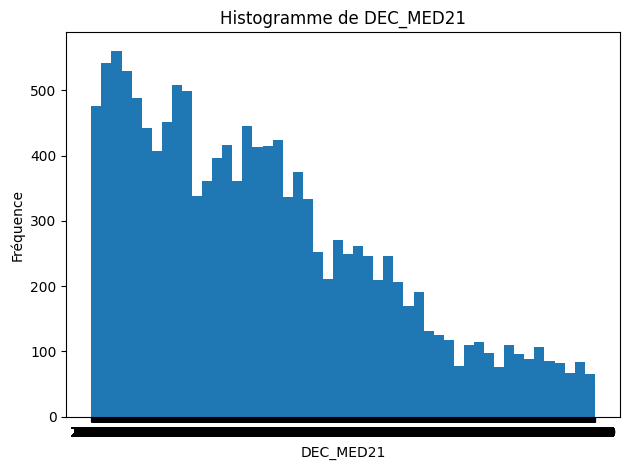

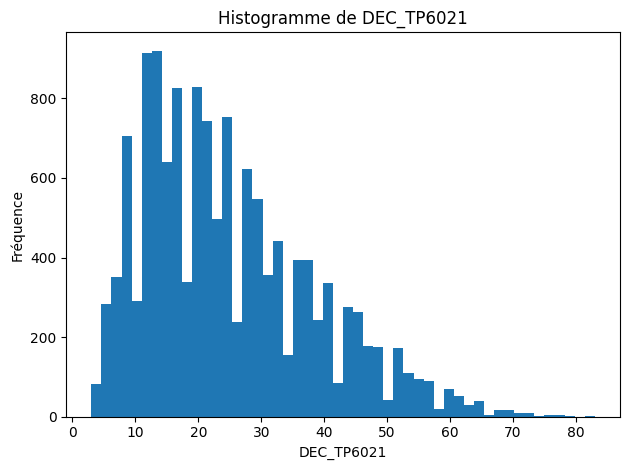

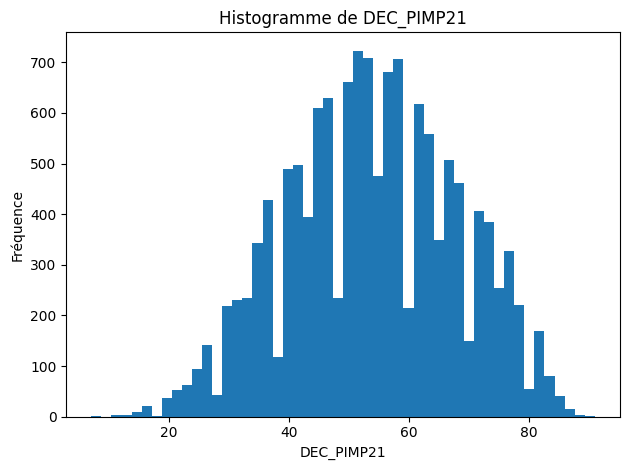

In [22]:
for col in vars_of_interest:
    data = subset[col]
    plt.figure()
    plt.hist(data, bins = 50)
    plt.title(f"Histogramme de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

On observe que les variables suivantes :

    - `DEC_MED21`   # Revenu médian

semblent toutes suivre une même loi.

En revanche, les variables suivantes :

    - `DEC_TP6021`  # Taux de pauvreté
    - `DEC_PIMP21`  # Part des impôts

semblent, chacune, suivre une loi différente.

Nous proposons donc de construire trois estimateurs distincts afin d’estimer ces trois lois :
1. la loi du revenu médian (et des indicateurs associés),
2. la loi du taux de pauvreté,
3. la loi de la part des impôts.

D’après les histogrammes obtenus, nous formulons les hypothèses de lois paramétriques suivantes :
1. la première famille de variables suit une **loi gaussienne**,
2. le taux de pauvreté suit une **loi Gamma** ou une **loi log-normale**,
3. la part des impôts suit une **loi log-normale**.


On va dans un premier temps s'intérreser à la variable DEC_MED21. Soit le revenu moyen . Si on regarde la densité des valeurs on peut penser que le revenu moyen suit une loi log normale : 

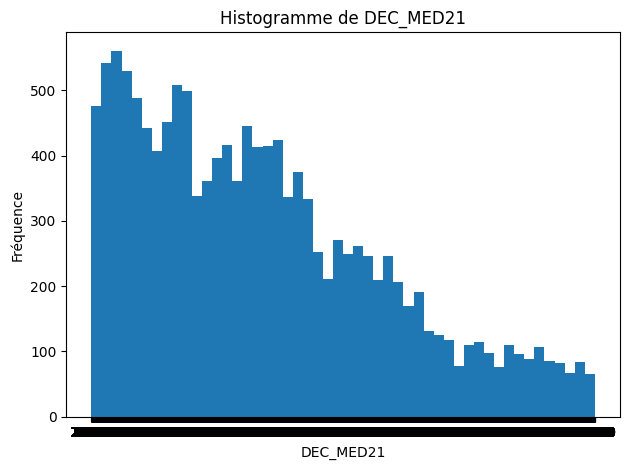

In [23]:
df

,IRIS,DEC_PIMP21,DEC_TP6021,DEC_INCERT21,DEC_Q121,DEC_MED21,DEC_Q321,DEC_EQ21,DEC_D121,DEC_D221,...,DEC_RD21,DEC_S80S2021,DEC_GI21,DEC_PACT21,DEC_PTSA21,DEC_PCHO21,DEC_PBEN21,DEC_PPEN21,DEC_PAUT21,DEC_NOTE21
0,010040101,43.0,29.0,2,12610,19330,26390,0.71,7760,11300,...,4.4,6.3,0.318,69.3,62.5,3.2,3.6,27.1,3.6,0
1,010040102,42.0,39.0,1,9730,16830,24620,0.89,4680,8600,...,7.1,9.0,0.362,70.5,63.7,4.4,2.4,25.6,3.9,0
2,010040201,47.0,29.0,1,12220,19940,27650,0.77,6500,10300,...,5.7,8.0,0.352,69.3,61.9,3.6,3.8,26.7,4.0,0
3,010040202,62.0,14.0,1,18350,25560,35010,0.65,11960,16450,...,3.8,6.3,0.360,65.5,60.0,2.3,3.2,21.8,12.7,0
4,010330102,42.0,31.0,1,11280,19870,30050,0.94,5250,9790,...,8.5,10.6,0.390,74.1,67.5,4.8,1.8,23.0,2.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16010,974221001,26.0,50.0,1,7080,13620,23560,1.21,1810,5890,...,19.0,19.1,0.446,79.6,61.5,6.6,11.5,15.8,4.6,0
16011,974221101,27.0,47.0,2,7420,14350,24410,1.18,1810,6360,...,19.1,17.6,0.433,78.8,61.5,6.1,11.2,16.6,4.6,0
16017,974230101,25.0,50.0,1,6800,13730,22760,1.16,1250,5170,...,26.6,18.2,0.424,77.8,65.5,7.1,5.2,19.2,3.0,0
16018,974230102,25.0,53.0,1,6170,12550,21750,1.24,740,4650,...,41.4,25.1,0.447,83.7,70.2,7.2,6.3,13.5,2.8,0


Vérifions que `DEC_MED21` suis bien une loie log normal pour se faire nous allons dans un premier temps vérifier la distibution de `log(DEC_MED21)` et enfin l'adéquation à une loi normale 

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


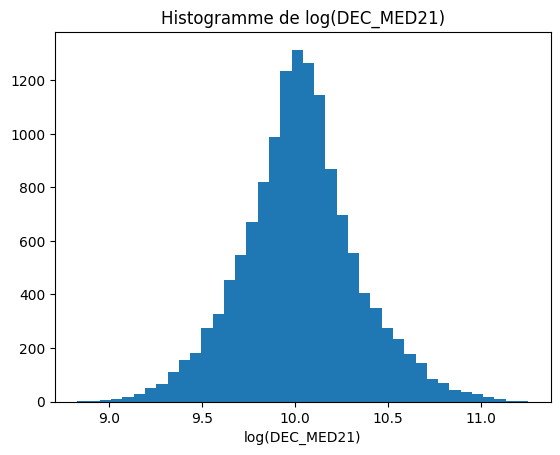

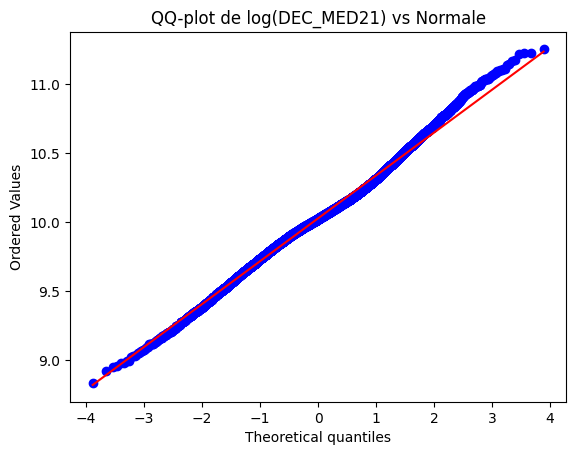

In [ ]:
sub = df["DEC_MED21"].dropna().astype(np.number).to_frame()
sub["IRIS"] = df.loc[sub.index, "IRIS"]
x= sub["DEC_MED21"]

x = np.asarray(x)
logx = np.log(x)

plt.figure()
plt.hist(logx, bins=40)
plt.title("Histogramme de log(DEC_MED21)")
plt.xlabel("log(DEC_MED21)")
plt.show()

# QQ-plot (approx) via probplot
plt.figure()
stats.probplot(logx, dist="norm", plot=plt)
plt.title("QQ-plot de log(DEC_MED21) vs Normale")
plt.show()


## Estimation des paramètres d’une loi log-normale

### Estimations par le maximum de vraissemblance 

On suppose que `Y = log(X) ~ N(μ, σ²)`.

Soit un échantillon `(x₁,…,xₙ)` avec `xᵢ > 0` et `yᵢ = log(xᵢ)`.


JUSTIFIER CETTE FORMULE FAIRE LES CALCULS 


Estimateurs MV :

- `μ̂ = (1/n) ∑ yᵢ`
- `σ̂² = (1/n) ∑ (yᵢ − μ̂)²`

Les paramètres de la loi log-normale sont `μ = μ̂` et `σ = √(σ̂²)`.


In [ ]:
# moyenne empirique
moy_emp = np.mean(logx)

# variance empirique (non biaisée)
var_emp_unb = np.var(logx, ddof=1)


print("Moyenne empirique (logx) =", moy_emp)
print("Variance empirique non biaisée (ddof=1) =", var_emp_unb)

In [ ]:
n = len(logx)

# moyenne
mu_hat = (1/n) * np.sum(logx)

# variance non biaisée (ddof=1)
sigma2_hat = (1/(n-1)) * np.sum((logx - mu_hat)**2)

# écart-type
sigma_hat = np.sqrt(sigma2_hat)

#### Vérifions les propriétes des estimateurs 

verifions la loi forte des grand nombre 

(mettre la formule)
 theorme de la limite centrale 

 (mettre formule )

 verifier si c'est une optimisation optimatle 

#### Estimations par la méthode des moments 